# Assessment Task 1

## Data preparation

In [1]:
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Import training data
df_train = pd.read_csv('../data/raw/train.csv')

In [3]:
# Drop ID column
df_train = df_train.drop(['Id_old','Id'], axis=1)

# Identify target
features = df_train.iloc[:,:-1].to_numpy()
target = df_train.iloc[:,-1].to_numpy()

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Save scaler into models folder
dump(scaler, '../models/David/scaler.joblib')

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=8)

# Save split datasets into data folder
#np.save('../data/processed/X_train', X_train)
#np.save('../data/processed/X_val',   X_val)
#np.save('../data/processed/X_test',  X_test)
#np.save('../data/processed/y_train', y_train)
#np.save('../data/processed/y_val',   y_val)
#np.save('../data/processed/y_test',  y_test)

## Logistic Regression - default

In [4]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [5]:
# Save fitted model into model folder
dump(reg,  '../models/David/log_reg.joblib')

In [6]:
# Model predictions on training and validation data
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

In [7]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix \n", cm_val)

Confusion Matrix 
 [[   5  252]
 [  12 1331]]


ROC_AUC: 0.7073251996952058


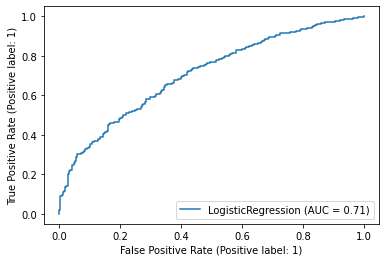

In [8]:
# Calculate and plot ROC_AUC
y_score = log_reg.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(log_reg, X_val, y_val)

## Logistic Regression - ElasticNet

In [9]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegression 

log_reg_elastic = LogisticRegression(
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=0.5)

log_reg_elastic.fit(X_train, y_train)

C:\Users\David Anker\anaconda3\envs\adv_dsi\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [10]:
# Save fitted model into model folder
dump(reg,  '../models/David/log_reg_elastic.joblib')

In [11]:
# Model predictions on training and validation data
y_train_pred = log_reg_elastic.predict(X_train)
y_val_pred = log_reg_elastic.predict(X_val)

In [12]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix \n", cm_val)

Confusion Matrix 
 [[   5  252]
 [  11 1332]]


ROC_AUC: 0.7067428458848446


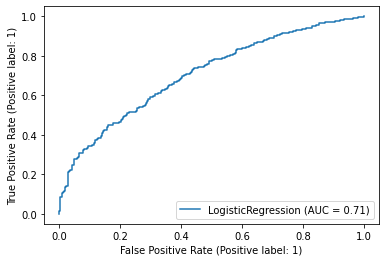

In [53]:
# Calculate and plot ROC_AUC
y_score = log_reg_elastic.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(log_reg_elastic, X_val, y_val)

## Logistic Regression CV

In [14]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegressionCV 

C_list = np.linspace(0.001, 0.5, 20)

log_reg_cv = LogisticRegressionCV(
    Cs=C_list, 
    cv=20,
    penalty='l1',
    scoring='roc_auc', 
    solver='liblinear',
    tol =1e-4, 
    max_iter=1000, 
    class_weight='balanced', 
    n_jobs=10, #7
    verbose=2, 
    refit=True, 
    multi_class='ovr', 
    random_state=42)

log_reg_cv.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:   21.9s remaining:   14.6s


[LibLinear]

[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   25.9s finished


LogisticRegressionCV(Cs=array([0.001     , 0.02726316, 0.05352632, 0.07978947, 0.10605263,
       0.13231579, 0.15857895, 0.18484211, 0.21110526, 0.23736842,
       0.26363158, 0.28989474, 0.31615789, 0.34242105, 0.36868421,
       0.39494737, 0.42121053, 0.44747368, 0.47373684, 0.5       ]),
                     class_weight='balanced', cv=20, max_iter=1000,
                     multi_class='ovr', n_jobs=10, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear',
                     verbose=2)

In [15]:
# Save fitted model into model folder
dump(reg,  '../models/David/log_reg_cv.joblib')

In [16]:
# Model predictions on training and validation data
y_train_pred = log_reg_cv.predict(X_train)
y_val_pred = log_reg_cv.predict(X_val)

In [17]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix \n", cm_val)

Confusion Matrix 
 [[168  89]
 [505 838]]


ROC_AUC: 0.7054303768495528


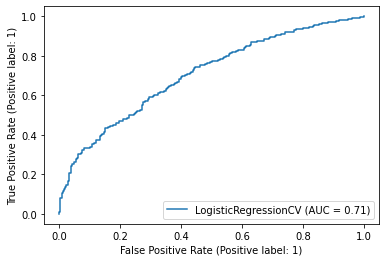

In [52]:
# Calculate and plot ROC_AUC
y_score = log_reg_cv.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(log_reg_cv, X_val, y_val)

## Random Forest - default

In [41]:
# Create and fit classifier
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
# Save fitted model into model folder
dump(reg,  '../models/David/random_forest.joblib')

In [43]:
# Model predictions on training and validation data
y_train_pred = random_forest.predict(X_train)
y_val_pred = random_forest.predict(X_val)

In [44]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix \n", cm_val)

Confusion Matrix 
 [[  16  241]
 [  23 1320]]


ROC_AUC: 0.6533328890833285


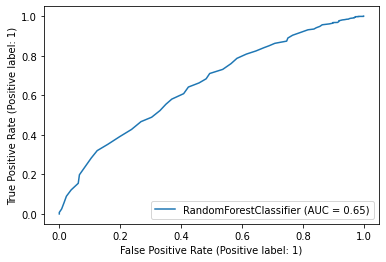

In [51]:
# Calculate and plot ROC_AUC
y_score = random_forest.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(random_forest, X_val, y_val)

## Random Forest - second attempt

In [46]:
# Create and fit classifier
from sklearn.ensemble import RandomForestClassifier

random_forest2 = RandomForestClassifier(
    n_estimators=5, 
    criterion='entropy', 
    max_depth=15, 
    min_samples_split=3, 
    random_state=42, 
    verbose=1, 
    class_weight='balanced' 
)

random_forest2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=3, n_estimators=5,
                       random_state=42, verbose=1)

In [47]:
# Save fitted model into model folder
dump(reg,  '../models/David/random_forest2.joblib')

In [48]:
# Model predictions on training and validation data
y_train_pred = random_forest2.predict(X_train)
y_val_pred = random_forest2.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [49]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix \n", cm_val)

Confusion Matrix 
 [[  64  193]
 [ 179 1164]]


ROC_AUC: 0.6407282609640419


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


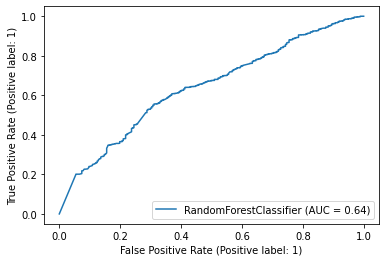

In [54]:
# Calculate and plot ROC_AUC
y_score = random_forest2.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(random_forest2, X_val, y_val)

## Support Vector Classification - default

In [74]:
# Create and fit classifier
from sklearn.svm import SVC

svm = SVC(kernel = 'sigmoid', probability=True)

svm.fit(X_train, y_train)

SVC(kernel='sigmoid', probability=True)

In [75]:
# Save fitted model into model folder
dump(reg,  '../models/David/svm.joblib')

In [76]:
# Model predictions on training and validation data
y_train_pred = svm.predict(X_train)
y_val_pred = svm.predict(X_val)

In [77]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix \n", cm_val)

Confusion Matrix 
 [[  49  208]
 [ 199 1144]]


ROC_AUC: 0.5793116635907182


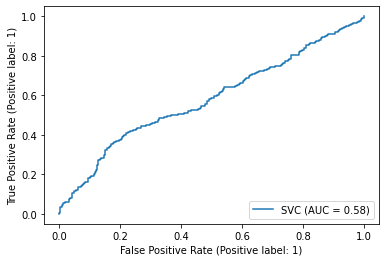

In [78]:
# Calculate and plot ROC_AUC
y_score = svm.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(svm, X_val, y_val)

## Calculate predictions on test data

In [ ]:
# Import test data
df_test = pd.read_csv('../data/raw/test.csv')

In [ ]:
# Drop ID column
df_test = df_test.drop(['Id_old','Id'], axis=1)

# Standardize features
df_test = scaler.fit_transform(df_test)

In [ ]:
# Predict target probabilities (use specific model name)
test_probs = log_reg_cv.predict_proba(df_test)[:,1]

In [ ]:
# Create dataframe object
test_probs_df = pd.DataFrame(test_probs, columns = ["TARGET_5Yrs"])

In [ ]:
# Name 'ID' column
test_probs_df.index.name = "Id"

In [ ]:
# Save output to csv
test_probs_df.to_csv("final.csv")